Spark version: 3.5.1
Upload your CSV (e.g., heart.csv)…


Saving heart-disease.csv to heart-disease (2).csv
Raw rows: 303
root
 |-- ID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Angina: double (nullable = true)
 |-- Blood_Pressure: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Glycemia: double (nullable = true)
 |-- ECG: double (nullable = true)
 |-- Heart_Rate: double (nullable = true)
 |-- Angina_After_Sport: double (nullable = true)
 |-- ECG_Angina: double (nullable = true)
 |-- ECG_Slope: double (nullable = true)
 |-- Fluoroscopy: string (nullable = true)
 |-- Thalassaemia: string (nullable = true)
 |-- Disease: integer (nullable = true)

Clean rows: 297
Columns: ['Age', 'Sex', 'Angina', 'Blood_Pressure', 'Cholesterol', 'Glycemia', 'ECG', 'Heart_Rate', 'Angina_After_Sport', 'ECG_Angina', 'ECG_Slope', 'Fluoroscopy', 'Thalassemia', 'Disease']
+-------+-------------+-----+
|Disease|DiseaseBinary|count|
+-------+-------------+-----+
|0      |0            |16

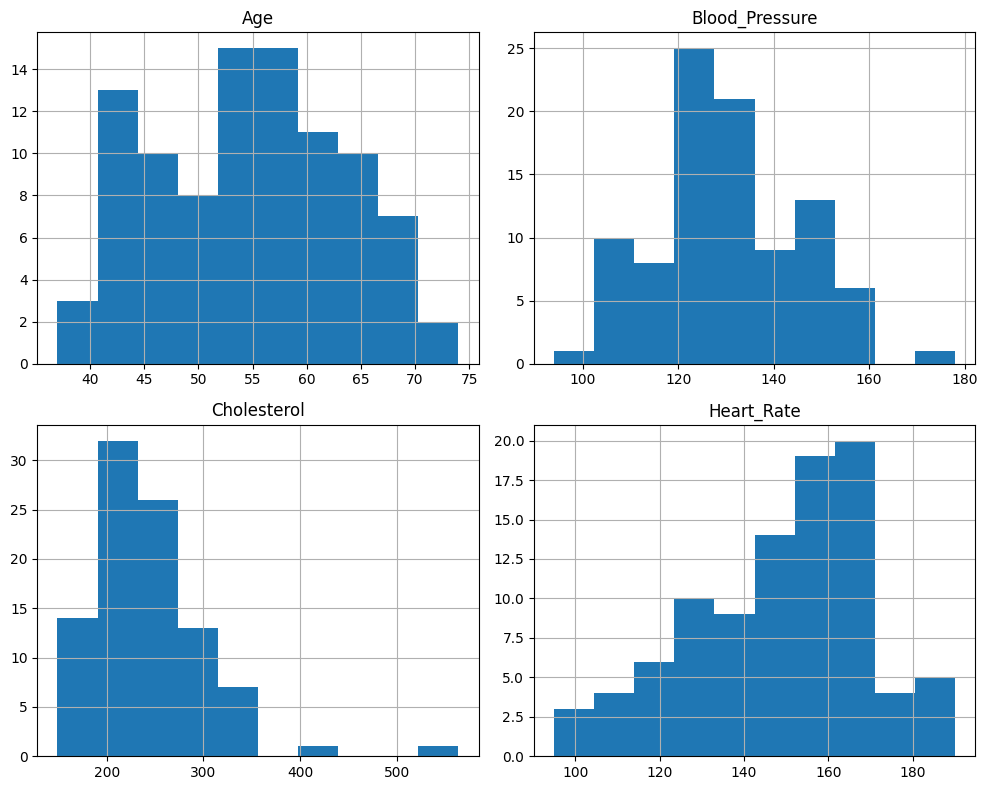

Train: 202 Test: 95
Fitting Logistic Regression…
Fitting Random Forest…
Fitting GBT…

=== Model Comparison ===
             Model  Accuracy     F1  Precision  Recall   AUPR  AUROC
LogisticRegression    0.8526 0.8519     0.8543  0.8526 0.9362 0.9300
      RandomForest    0.8105 0.8105     0.8105  0.8105 0.9294 0.9242
               GBT    0.7579 0.7577     0.7576  0.7579 0.8060 0.8583

== Confusion Matrix: LogisticRegression ==
   prediction  DiseaseBinary  count
0         0.0              0     46
1         0.0              1      9
2         1.0              0      5
3         1.0              1     35

== Confusion Matrix: RandomForest ==
   prediction  DiseaseBinary  count
0         0.0              0     42
1         0.0              1      9
2         1.0              0      9
3         1.0              1     35

== Confusion Matrix: GBT ==
   prediction  DiseaseBinary  count
0         0.0              0     40
1         0.0              1     12
2         1.0              0     1

In [ ]:
# ============================================
# Cardiovascular Risk - PySpark E2E (Colab)
# ============================================
!pip -q install pyspark==3.5.1

from google.colab import files
import shutil, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# -----------------------
# Spark session
# -----------------------
spark = SparkSession.builder.appName("CV_Risk_Pipeline").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
print("Spark version:", spark.version)

# -----------------------
# Upload CSV
# -----------------------
print("Upload your CSV (e.g., heart.csv)…")
uploaded = files.upload()
csv_path = next(iter(uploaded))
df = spark.read.csv(csv_path, header=True, inferSchema=True)
print("Raw rows:", df.count())
df.printSchema()

# ======================================================
# FIX BLOCK: normalize column names & data types
# - rename Thalassaemia -> Thalassemia
# - drop ID if present
# - map Sex strings to 0/1 if needed
# - cast numerics/categoricals + drop nulls
# ======================================================
df = df.toDF(*[c.strip().replace(" ", "_") for c in df.columns])  # strip spaces

if "Thalassaemia" in df.columns and "Thalassemia" not in df.columns:
    df = df.withColumnRenamed("Thalassaemia", "Thalassemia")

if "ID" in df.columns:
    df = df.drop("ID")

# If Sex is string labels, map to ints; otherwise cast
if "Sex" in df.columns:
    peek = df.select("Sex").limit(50).toPandas()["Sex"].astype(str).str.lower()
    if peek.str.contains("female").any() or peek.str.contains("male").any():
        df = df.withColumn(
            "Sex",
            F.when(F.lower(F.col("Sex")).isin("female","f","0"), F.lit(0))
             .when(F.lower(F.col("Sex")).isin("male","m","1"), F.lit(1))
             .otherwise(F.col("Sex").cast("int"))
        )
    else:
        df = df.withColumn("Sex", F.col("Sex").cast("int"))

# Cast numerics
num_cols = ["Age","Blood_Pressure","Cholesterol","Heart_Rate","ECG_Angina"]
for c in num_cols:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("double"))

# Cast categoricals (coded ints)
cat_cols = ["Sex","Angina","Glycemia","ECG","Angina_After_Sport","ECG_Slope","Fluoroscopy","Thalassemia","Disease"]
for c in cat_cols:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("int"))

df = df.na.drop()
print("Clean rows:", df.count())
print("Columns:", df.columns)

# Binarize target: DiseaseBinary = 1 if Disease>0 else 0
if "Disease" not in df.columns:
    raise ValueError("Expected column 'Disease' not found.")
df = df.withColumn("DiseaseBinary", F.when(F.col("Disease") > 0, 1).otherwise(0).cast("int"))
label_col = "DiseaseBinary"

# -----------------------
# Quick sanity check
# -----------------------
df.groupBy("Disease","DiseaseBinary").count().orderBy("Disease").show(truncate=False)

# -----------------------
# Simple EDA (plots)
# -----------------------
sample_pdf = df.select("Age","Blood_Pressure","Cholesterol","Heart_Rate","DiseaseBinary") \
               .sample(False, 0.3, seed=42).toPandas()

fig, axes = plt.subplots(2,2, figsize=(10,8))
sample_pdf["Age"].hist(ax=axes[0,0]); axes[0,0].set_title("Age")
sample_pdf["Blood_Pressure"].hist(ax=axes[0,1]); axes[0,1].set_title("Blood_Pressure")
sample_pdf["Cholesterol"].hist(ax=axes[1,0]); axes[1,0].set_title("Cholesterol")
sample_pdf["Heart_Rate"].hist(ax=axes[1,1]); axes[1,1].set_title("Heart_Rate")
plt.tight_layout(); plt.show()

# -----------------------
# Preprocessing
# -----------------------
categorical_cols = [c for c in ["Sex","Angina","Glycemia","ECG","Angina_After_Sport","ECG_Slope","Fluoroscopy","Thalassemia"] if c in df.columns]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
ohe = OneHotEncoder(inputCols=[f"{c}_idx" for c in categorical_cols],
                    outputCols=[f"{c}_ohe" for c in categorical_cols],
                    dropLast=False)

numeric_cols = [c for c in ["Age","Blood_Pressure","Cholesterol","Heart_Rate","ECG_Angina"] if c in df.columns]
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol="num_vec", handleInvalid="keep")
scaler = StandardScaler(inputCol="num_vec", outputCol="num_scaled", withMean=True, withStd=True)

all_feature_cols = [f"{c}_ohe" for c in categorical_cols] + (["num_scaled"] if numeric_cols else [])
assembler_all = VectorAssembler(inputCols=all_feature_cols, outputCol="features", handleInvalid="keep")

# -----------------------
# Split
# -----------------------
train_df, test_df = df.randomSplit([0.7, 0.3], seed=7)
print("Train:", train_df.count(), "Test:", test_df.count())

# -----------------------
# Models
# -----------------------
lr  = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=50)
rf  = RandomForestClassifier(featuresCol="features", labelCol=label_col, numTrees=150, maxDepth=8, seed=7)
gbt = GBTClassifier(featuresCol="features", labelCol=label_col, maxIter=100, maxDepth=5, stepSize=0.1, seed=7)

base_stages = indexers + [ohe, assembler_num, scaler, assembler_all]
pipe_lr  = Pipeline(stages=base_stages + [lr])
pipe_rf  = Pipeline(stages=base_stages + [rf])
pipe_gbt = Pipeline(stages=base_stages + [gbt])

# -----------------------
# CV (tiny grids for speed)
# -----------------------
evaluator_f1   = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
evaluator_acc  = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
evaluator_pr   = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
evaluator_re   = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")
evaluator_aupr = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderPR")
evaluator_auroc= BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

grid_lr = (ParamGridBuilder()
           .addGrid(lr.regParam, [0.0, 0.01, 0.1])
           .addGrid(lr.elasticNetParam, [0.0, 0.5])
           .build())
grid_rf = (ParamGridBuilder()
           .addGrid(rf.numTrees, [100, 150])
           .addGrid(rf.maxDepth, [6, 8])
           .build())
grid_gbt = (ParamGridBuilder()
            .addGrid(gbt.maxDepth, [3, 5])
            .addGrid(gbt.maxIter, [50, 100])
            .build())

print("Fitting Logistic Regression…")
cv_lr  = CrossValidator(estimator=pipe_lr,  estimatorParamMaps=grid_lr,  evaluator=evaluator_f1, numFolds=3).fit(train_df)
print("Fitting Random Forest…")
cv_rf  = CrossValidator(estimator=pipe_rf,  estimatorParamMaps=grid_rf,  evaluator=evaluator_f1, numFolds=3).fit(train_df)
print("Fitting GBT…")
cv_gbt = CrossValidator(estimator=pipe_gbt, estimatorParamMaps=grid_gbt, evaluator=evaluator_f1, numFolds=3).fit(train_df)

# -----------------------
# Evaluation
# -----------------------
def evaluate(model, name):
    preds = model.transform(test_df).cache()
    res = {
        "Model": name,
        "Accuracy":  round(evaluator_acc.evaluate(preds), 4),
        "F1":        round(evaluator_f1.evaluate(preds), 4),
        "Precision": round(evaluator_pr.evaluate(preds), 4),
        "Recall":    round(evaluator_re.evaluate(preds), 4),
        "AUPR":      round(evaluator_aupr.evaluate(preds), 4),
        "AUROC":     round(evaluator_auroc.evaluate(preds), 4),
        "cm":        preds.groupBy("prediction", label_col).count().orderBy("prediction", label_col).toPandas()
    }
    return res, preds

r_lr,  _ = evaluate(cv_lr.bestModel,  "LogisticRegression")
r_rf,  _ = evaluate(cv_rf.bestModel,  "RandomForest")
r_gbt, _ = evaluate(cv_gbt.bestModel, "GBT")

comp = pd.DataFrame([r_lr, r_rf, r_gbt])[["Model","Accuracy","F1","Precision","Recall","AUPR","AUROC"]].sort_values("F1", ascending=False)
print("\n=== Model Comparison ===")
print(comp.to_string(index=False))

for r in [r_lr, r_rf, r_gbt]:
    print(f"\n== Confusion Matrix: {r['Model']} ==")
    print(r["cm"])

best_name = comp.iloc[0]["Model"]
print("\nBest model by F1:", best_name)
best_model = {"LogisticRegression": cv_lr.bestModel,
              "RandomForest":      cv_rf.bestModel,
              "GBT":               cv_gbt.bestModel}[best_name]

# -----------------------
# Interpretability (quick)
# -----------------------
def get_feature_names(pipeline_model, sample_df):
    meta = pipeline_model.transform(sample_df.limit(1)).schema["features"].metadata
    names = []
    if meta and "ml_attr" in meta and "attrs" in meta["ml_attr"]:
        attrs = meta["ml_attr"]["attrs"]
        for k in ["binary", "nominal", "numeric"]:
            if k in attrs:
                names.extend([a["name"] for a in attrs[k]])
    else:
        # fallback generic names
        feat_len = len(pipeline_model.transform(sample_df.limit(1)).select("features").first()["features"])
        names = [f"f_{i}" for i in range(feat_len)]
    return names

feature_names = get_feature_names(best_model, df)

if best_name in ("RandomForest","GBT"):
    clf = best_model.stages[-1]
    imps = clf.featureImportances.toArray()
    top = sorted(zip(feature_names, imps), key=lambda x: x[1], reverse=True)[:20]
    print(f"\nTop 20 Feature Importances ({best_name}):")
    for n,v in top:
        print(f"{n:35s} {v:.4f}")
else:
    clf = best_model.stages[-1]
    coefs = clf.coefficients.toArray()
    top = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)[:20]
    print("\nTop 20 |Coefficient| (LogisticRegression):")
    for n,v in top:
        print(f"{n:35s} {v:+.4f}")

# -----------------------
# Save pipeline
# -----------------------
save_dir = f"/content/models/{best_name}_pipeline"
shutil.rmtree(save_dir, ignore_errors=True)
best_model.write().overwrite().save(save_dir)
print("Saved best pipeline to:", save_dir)

# -----------------------
# Sample predictions
# -----------------------
sample_pd = pd.DataFrame([
    [54, 1, 2, 140, 250, 1, 1, 150, 1, 1.2, 2, 1, 6],
    [42, 0, 1, 120, 190, 0, 0, 170, 0, 0.2, 1, 0, 3],
], columns=["Age","Sex","Angina","Blood_Pressure","Cholesterol","Glycemia","ECG","Heart_Rate","Angina_After_Sport","ECG_Angina","ECG_Slope","Fluoroscopy","Thalassemia"])
sample_sdf = spark.createDataFrame(sample_pd)
preds_new = best_model.transform(sample_sdf)
preds_new.select("Age","Sex","Blood_Pressure","Cholesterol","prediction","probability").show(truncate=False)
